In [ ]:
! pip install tensorflow_addons
! pip install wget

     |████████████████████████████████| 1.1 MB 4.2 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=8a9bbcecc1e3370cb5af2ffa8afd70b9628ab039e08fb154e1b15c3585b3003e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K


def mean_squared_error(y_true, y_pred):
	""" loss function computing MSE of non-blank(!=0) in y_true
		Args:
			y_true(tftensor): true label
			y_pred(tftensor): predicted label
		return:
			MSE reconstruction error for loss computing
	"""
	loss = K.switch(K.equal(y_true, tf.constant(0.)),tf.zeros(K.shape(y_true)),K.square(y_pred - y_true))
	return K.mean(loss, axis=-1)

def triplet_loss(margin = 1.0):
    def inner_triplet_loss_objective(y_true, y_pred):
        #print(y_true, y_pred)
        labels = y_true
        embeddings = y_pred
        return tfa.losses.triplet_semihard_loss(y_true=labels, y_pred=embeddings,margin=margin)
    return inner_triplet_loss_objective

def SparseCategoricalCrossentropy(class_weight = None):
    """[SparseCategoricalCrossentropy]
    Args:
        class_weight ([dict], optional): dict of class_weight
        class_weight = {0: 0.3,
                        1: 0.7}
        Defaults to None.
    """
    def inner_sparse_categorical_crossentropy(y_true, y_pred):
        scce = tf.keras.losses.SparseCategoricalCrossentropy()
        if class_weight:
            keys_tensor = tf.cast(tf.constant(list(class_weight.keys())), dtype=tf.int32)
            vals_tensor = tf.constant(list(class_weight.values()), tf.float32)
            input_tensor = tf.cast(y_true, dtype=tf.int32)
            init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
            table = tf.lookup.StaticHashTable(init, default_value=-1)
            sample_weight = table.lookup(input_tensor)
        else:
            sample_weight = None
        return scce(y_true, y_pred, sample_weight)
    return inner_sparse_categorical_crossentropy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import csv
from scipy import signal
from scipy.signal import butter, filtfilt
import wget
import os
import time
import tensorflow as tf
from sklearn.utils import class_weight
from scipy.interpolate import CubicSpline 
from scipy import ndimage
import argparse

# lib path
#PATH = os.path.dirname(os.path.realpath(__file__))
PATH = '/content/'

def load_raw(dataset):
    # folder_name = str(PATH)+'/datasets'
    folder_name = 'datasets'
    if dataset == 'OpenBMI':
        try:
            num_subjects = 54
            sessions = [1, 2]
            save_path = folder_name + '/' + dataset + '/raw'
            if save_path is not None:
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
            for session in sessions:
                for person in range(1, num_subjects+1):
                    file_name = '/sess{:02d}_subj{:02d}_EEG_MI.mat'.format(session,person)
                    if os.path.exists(save_path+file_name):
                        os.remove(save_path+file_name) # if exist, remove file
                    print('\n===Download is being processed on session: {} subject: {}==='.format(session, person))
                    url = 'ftp://parrot.genomics.cn/gigadb/pub/10.5524/100001_101000/100542/session{}/s{}{}'.format(session, person, file_name)
                    print('save to: '+save_path+file_name)
                    wget.download(url,  save_path+file_name)
            print('\nDone!')
        except:
            raise Exception('Path Error: file does not exist, please direccly download at http://gigadb.org/dataset/100542')
    elif dataset == 'BCIC2a':
        try:
            num_subjects = 9
            sessions = ['T', 'E']
            save_path = folder_name + '/' + dataset + '/raw'
            if save_path is not None:
                if not os.path.exists(save_path):
                    os.makedirs(save_path)

            for session in sessions:
                for person in range(1, num_subjects+1):
                    file_name = '/A{:02d}{}.mat'.format(person, session)
                    if os.path.exists(save_path+file_name):
                        os.remove(save_path+file_name) # if exist, remove file
                    print('\n===Download is being processed on session: {} subject: {}==='.format(session, person))
                    url = 'https://lampx.tugraz.at/~bci/database/001-2014'+file_name
                    print('save to: '+save_path+file_name)
                    wget.download(url, save_path+file_name)
            print('\nDone!')
        except:
            raise Exception('Path Error: file does not exist, please direccly download at http://bnci-horizon-2020.eu/database/data-sets')
    elif dataset == 'SMR_BCI':
        try:
            num_subjects = 14
            sessions = ['T', 'E']
            save_path = folder_name + '/' + dataset + '/raw'
            if save_path is not None:
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
            for session in sessions:
                for person in range(1, num_subjects+1):
                    file_name = '/S{:02d}{}.mat'.format(person, session)
                    if os.path.exists(save_path+file_name):
                        os.remove(save_path+file_name) # if exist, remove file
                    print('\n===Download is being processed on session: {} subject: {}==='.format(session, person))
                    url = 'https://lampx.tugraz.at/~bci/database/002-2014'+file_name
                    print('save to: '+save_path+file_name)
                    wget.download(url,  save_path+file_name)
            print('\nDone!')
        except:
            raise Exception('Path Error: file does not exist, please direccly download at http://bnci-horizon-2020.eu/database/data-sets')

class DataLoader:
    def __init__(self, dataset, train_type=None, data_type=None, num_class=2, subject=None, data_format=None, dataset_path='/datasets', **kwargs):

        self.dataset = dataset #Dataset name: 'OpenBMI', 'SMR_BCI', 'BCIC2a'
        self.train_type = train_type # 'subject_dependent', 'subject_independent'
        self.data_type = data_type # 'fbcsp', 'spectral_spatial', 'time_domain'
        self.dataset_path = dataset_path
        self.subject = subject # id, start at 1
        self.data_format = data_format # 'channels_first', 'channels_last'
        self.fold = None # fold, start at 1
        self.prefix_name = 'S'
        self.num_class = num_class
        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])


        self.path = self.dataset_path+'/'+self.dataset+'/'+self.data_type+'/'+str(self.num_class)+'_class/'+self.train_type
    
    def _change_data_format(self, X):
        if self.data_format == 'NCTD':
            # (#n_trial, #channels, #time, #depth)
            X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        elif self.data_format == 'NDCT':
            # (#n_trial, #depth, #channels, #time)
            X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
        elif self.data_format == 'NTCD':
            # (#n_trial, #time, #channels, #depth)
            X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
            X = np.swapaxes(X, 1, 3)
        elif self.data_format == 'NSHWD':
            # (#n_trial, #Freqs, #height, #width, #depth)
            X = zero_padding(X)
            X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], 1)
        elif self.data_format == None:
            pass
        else:
            raise Exception('Value Error: data_format requires None, \'NCTD\', \'NDCT\', \'NTCD\' or \'NSHWD\', found data_format={}'.format(self.data_format))
        print('change data_format to \'{}\', new dimention is {}'.format(self.data_format, X.shape))
        return X

    def load_train_set(self, fold, **kwargs):
        self.fold = fold
        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])
    
        # load 
        X, y =  np.array([]),  np.array([])
        try:
            self.file_x = self.path+'/X_train_{}{:03d}_fold{:03d}.npy'.format(self.prefix_name, self.subject, self.fold)
            self.file_y = self.path+'/y_train_{}{:03d}_fold{:03d}.npy'.format(self.prefix_name, self.subject, self.fold)
            X = self._change_data_format(np.load(self.file_x))
            y = np.load(self.file_y)
        except:
            raise Exception('Path Error: file does not exist, please check this path {}, and {}'.format(self.file_x, self.file_y))
        return X, y

    def load_val_set(self, fold, **kwargs):
        self.fold = fold
        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])

        # load 
        X, y =  np.array([]),  np.array([])
        try:
            self.file_x = self.path+'/X_val_{}{:03d}_fold{:03d}.npy'.format(self.prefix_name, self.subject, self.fold)
            self.file_y = self.path+'/y_val_{}{:03d}_fold{:03d}.npy'.format(self.prefix_name, self.subject, self.fold)
            X = self._change_data_format(np.load(self.file_x))
            y = np.load(self.file_y)
        except:
            raise Exception('Path Error: file does not exist, please check this path {}, and {}'.format(self.file_x, self.file_y))
        return X, y
    
    def load_test_set(self, fold, **kwargs):
        self.fold = fold
        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])

        # load 
        X, y =  np.array([]),  np.array([])
        try:
            self.file_x = self.path+'/X_test_{}{:03d}_fold{:03d}.npy'.format(self.prefix_name, self.subject, self.fold)
            self.file_y = self.path+'/y_test_{}{:03d}_fold{:03d}.npy'.format(self.prefix_name, self.subject, self.fold)
            X = self._change_data_format(np.load(self.file_x))
            y = np.load(self.file_y)
        except:
            raise Exception('Path Error: file does not exist, please check this path {}, and {}'.format(self.file_x, self.file_y))
        return X, y

def compute_class_weight(y_train):
    """compute class balancing
    Args:
        y_train (list, ndarray): [description]
    Returns:
        (dict): class weight balancing
    """
    return dict(zip(np.unique(y_train), 
                    class_weight.compute_class_weight(class_weight='balanced',
                                                      classes=np.unique(y_train),
                                                      y=y_train))) 
        
def str2bool(v):
    if isinstance(v, bool):
       return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self, save_path=None):
        self.save_path = save_path
    def on_train_begin(self, logs={}):
        self.logs = []
        if self.save_path:
            write_log(filepath=self.save_path, data=['time_log'], mode='w')
    def on_epoch_begin(self, epoch, logs={}):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs={}):
        time_diff = time.time()-self.start_time
        self.logs.append(time_diff)
        if self.save_path:
            write_log(filepath=self.save_path, data=[time_diff], mode='a')

def write_log(filepath='test.log', data=[], mode='w'):
    '''
    filepath: path to save
    data: list of data
    mode: a = update data to file, w = write a new file
    '''
    try:
        with open(filepath, mode) as csvFile:
            writer = csv.writer(csvFile)
            writer.writerow(data)
    except IOError:
        raise Exception('I/O error')

def zero_padding(data, pad_size=4):
    if len(data.shape) != 4:
        raise Exception('Dimension is not match!, must have 4 dims')
    new_shape = int(data.shape[2]+(2*pad_size))
    data_pad = np.zeros((data.shape[0], data.shape[1], new_shape, new_shape))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_pad[i,j,:,:] = np.pad(data[i,j,:,:], [pad_size, pad_size], mode='constant')
    print(data_pad.shape)
    return data_pad 


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def resampling(data, new_smp_freq, data_len):
    if len(data.shape) != 3:
        raise Exception('Dimesion error', "--> please use three-dimensional input")
    new_smp_point = int(data_len*new_smp_freq)
    data_resampled = np.zeros((data.shape[0], data.shape[1], new_smp_point))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_resampled[i,j,:] = signal.resample(data[i,j,:], new_smp_point)
    return data_resampled

def psd_welch(data, smp_freq):
    if len(data.shape) != 3:
        raise Exception("Dimension Error, must have 3 dimension")
    n_samples,n_chs,n_points = data.shape
    data_psd = np.zeros((n_samples,n_chs,89))
    for i in range(n_samples):
        for j in range(n_chs):
            freq, power_den = signal.welch(data[i,j], smp_freq, nperseg=n_points)
            index = np.where((freq>=8) & (freq<=30))[0].tolist()
            # print("the length of---", len(index))
            data_psd[i,j] = power_den[index]
    return data_psd

In [ ]:
import matplotlib.pyplot as plt

def plot(y):
    plt.figure(figsize=(20, 5))
    nx = len(y)
    plt.plot( np.arange(nx),  y)
    plt.show()

   

In [ ]:
from tensorflow.keras.layers import Concatenate, AveragePooling2D, BatchNormalization, Conv2D, Dropout, Conv2DTranspose, Dense, Input, Reshape, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import backend as K

import numpy as np
import os
import time
from sklearn.metrics import classification_report, f1_score


class MIN2Net:
    def __init__(self,
                input_shape=(1,400,20), 
                num_class=2, 
                loss=[mean_squared_error, triplet_loss(margin=1.0), 'sparse_categorical_crossentropy'],
                loss_weights=[1., 1., 1.], 
                latent_dim = None,
                epochs=200,
                batch_size=32,
                optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                lr=1e-2,
                min_lr=1e-3,
                factor=0.5,
                patience=5, 
                es_patience=20,
                verbose=1,
                log_path='logs',
                model_name='MIN2Net', 
                **kwargs):
        D, T, C = input_shape
        self.latent_dim = latent_dim if latent_dim is not None else C if num_class==4 else 64
        self.latent_dim = 64
        self.num_class = num_class
        self.input_shape = input_shape
        self.loss = loss
        self.loss_weights = loss_weights
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.optimizer.lr = lr
        self.lr = lr
        self.min_lr = min_lr
        self.factor = factor
        self.patience = patience
        self.es_patience = es_patience
        self.verbose = verbose
        self.log_path = log_path
        self.model_name = model_name
        self.weights_dir = log_path+'/'+model_name+str(np.random.randint(100))+'_out_weights.tf'
        self.csv_dir = log_path+'/'+model_name+'_out_log.log'
        self.time_log = log_path+'/'+model_name+'_time_log.csv'

        # use **kwargs to set the new value of below args.
        self.f1_average = 'binary' if self.num_class == 2 else 'macro'
        self.data_format = 'channels_last'
        self.shuffle = False
        self.metrics = 'accuracy'
        self.monitor = 'val_loss'
        self.mode = 'min'
        self.save_best_only = True
        self.save_weight_only = True
        self.seed = 1234
        self.class_balancing = False
        # 'set params'
        self.subsampling_size = 100
        self.pool_size_1 = (1,T//self.subsampling_size)
        self.pool_size_2 = (1,4)
        self.filter_1 = C
        self.filter_2 = 32
        
        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])
        
        self.flatten_size = T//self.pool_size_1[1]//self.pool_size_2[1]
        
        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        K.set_image_data_format(self.data_format)
        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)
            
    def build(self):
        'encoder'
        encoder_input  = Input(self.input_shape)
        en_conv        = Conv2D(self.filter_1, (1, 64), activation='elu', padding="same", 
                                kernel_constraint=max_norm(2., axis=(0, 1, 2)))(encoder_input)
        #en_conv        = Conv2D(self.filter_1, (1, 64), activation='elu', padding="same", 
                              #  kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        en_conv        = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(en_conv)
        en_conv        = AveragePooling2D(pool_size=(1, 2))(en_conv)  

        en_conv        = Conv2D(self.filter_2*2, (1, 64), activation='elu', padding="same", 
                                kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        #en_conv        = Conv2D(self.filter_2*2, (1, 64), activation='elu', padding="same", 
                                #kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        en_conv        = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(en_conv)
        en_conv        = AveragePooling2D(pool_size=(1, 2))(en_conv)  


        en_conv        = Conv2D(self.filter_2, (1, 32), activation='elu', padding="same", 
                                kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        #en_conv        = Conv2D(self.filter_2, (1, 16), activation='elu', padding="same", 
                                #kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        en_conv        = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(en_conv)
        en_conv        = AveragePooling2D(pool_size=(1, 2))(en_conv)  
        

        en_conv        = Conv2D(self.filter_2, (1, 32), activation='elu', padding="same", 
                                kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
       # en_conv        = Conv2D(self.filter_2, (1, 16), activation='elu', padding="same", 
                                #kernel_constraint=max_norm(2., axis=(0, 1, 2)))(en_conv)
        en_conv        = BatchNormalization(axis=3, epsilon=1e-05, momentum=0.1)(en_conv)
        en_conv        = AveragePooling2D(pool_size=(1, 2))(en_conv)  
        
        en_conv        = Flatten()(en_conv)
        encoder_output = Dense(self.latent_dim, kernel_constraint=max_norm(0.5))(en_conv)
        encoder        = Model(inputs=encoder_input, outputs=encoder_output, name='encoder')
        encoder.summary()
        
        'decoder'
        decoder_input  = Input(shape=(self.latent_dim,), name='decoder_input')
        de_conv        = Dense(1*self.flatten_size*self.filter_2, activation='elu', 
                               kernel_constraint=max_norm(0.5))(decoder_input)
        de_conv        = Reshape((1, self.flatten_size, self.filter_2))(de_conv)
        de_conv        = Conv2DTranspose(filters=self.filter_2, kernel_size=(1, 32), 
                                         activation='elu', padding='same', strides=(1,2), 
                                         kernel_constraint=max_norm(2., axis=(0, 1, 2)))(de_conv)
        de_conv        = Conv2DTranspose(filters=self.filter_2, kernel_size=(1, 32), 
                                         activation='elu', padding='same', strides=(1,2), 
                                         kernel_constraint=max_norm(2., axis=(0, 1, 2)))(de_conv)
        de_conv        = Conv2DTranspose(filters=self.filter_2*2, kernel_size=(1, 64), 
                                         activation='elu', padding='same', strides=(1,2), 
                                         kernel_constraint=max_norm(2., axis=(0, 1, 2)))(de_conv)

        decoder_output = Conv2DTranspose(filters=self.filter_1, kernel_size=(1, 64), 
                                         activation='elu', padding='same', strides=(1,2), 
                                         kernel_constraint=max_norm(2., axis=(0, 1, 2)))(de_conv)
        decoder        = Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
        decoder.summary()

        'Build the computation graph for training'
        latent         = encoder(encoder_input)
        train_xr       = decoder(latent)
        x = latent
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = Dense(32, activation='relu')(x)
        z              = Dense(self.num_class, activation='softmax', kernel_constraint=max_norm(0.5), 
                               name='classifier')(x)

        return Model(inputs=encoder_input, outputs=[train_xr, latent,  z], 
                            name='MIN2Net')
    
    def fit(self,  X_train, y_train, X_val, y_val):
            
        if X_train.ndim != 4:
            raise Exception('ValueError: `X_train` is incompatible: expected ndim=4, found ndim='+str(X_train.ndim))
        elif X_val.ndim != 4:
            raise Exception('ValueError: `X_val` is incompatible: expected ndim=4, found ndim='+str(X_val.ndim))

        csv_logger    = CSVLogger(self.csv_dir)
        time_callback = TimeHistory(self.time_log)
        checkpointer  = ModelCheckpoint(monitor=self.monitor, filepath=self.weights_dir, 
                                        verbose=self.verbose, save_best_only=self.save_best_only, 
                                        save_weight_only=self.save_weight_only)
        reduce_lr     = ReduceLROnPlateau(monitor=self.monitor, patience=self.patience, 
                                          factor=self.factor, mode=self.mode, verbose=self.verbose, 
                                          min_lr=self.min_lr)
        es            = EarlyStopping(monitor=self.monitor, mode=self.mode, verbose=self.verbose, 
                                      patience=self.es_patience)
        if self.class_balancing: # compute_class_weight if class_balancing is True
            class_weight  = compute_class_weight(y_train)
            self.loss[-1] = SparseCategoricalCrossentropy(class_weight=class_weight)
        
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics, loss_weights=self.loss_weights)

        model.fit(x=X_train, y=[X_train, y_train,y_train],
                          batch_size=self.batch_size, shuffle=self.shuffle,
                          epochs=self.epochs, validation_data=(X_val, [X_val,y_val, y_val]),
                          callbacks=[checkpointer,csv_logger,reduce_lr,es, time_callback])
        
    def predict(self, X_test, y_test):

        if X_test.ndim != 4:
            raise Exception('ValueError: `X_test` is incompatible: expected ndim=4, found ndim='+str(X_test.ndim))

        model = self.build()
        model.summary()
        model.load_weights(self.weights_dir)
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics, loss_weights=self.loss_weights)

        start = time.time()
        y_pred_decoder, y_pred_trip, y_pred_clf = model.predict(X_test)
        end = time.time()
        loss, decoder_loss, trip_loss, classifier_loss, decoder_acc, trip_acc, classifier_acc  = model.evaluate(x=X_test,
                                                                                                                y=[X_test,y_test,y_test],
                                                                                                                batch_size=self.batch_size, 
                                                                                                                verbose=self.verbose)
        y_pred_argm = np.argmax(y_pred_clf, axis=1)
        print("F1-score is computed based on {}".format(self.f1_average))
        f1 = f1_score(y_test, y_pred_argm, average=self.f1_average)
        print('(loss: {}, accuracy: {})'.format(loss, classifier_acc))
        print(classification_report(y_test, y_pred_argm))
        evaluation = {'loss': loss, 
                      'decoder_loss': decoder_loss, 
                      'triplet_loss':trip_loss, 
                      'classifier_loss': classifier_loss, 
                      'accuracy': classifier_acc,
                      'f1-score': f1 ,
                      'prediction_time': end-start}
        Y = {'y_true': y_test,
             'y_pred': y_pred_argm,
             'y_pred_decoder': y_pred_decoder}

        return Y, evaluation

In [ ]:
Xs1 = np.load("/content/drive/MyDrive/MSU_Dataset/s1_test_xs400.npy")
ys1 = np.load("/content/drive/MyDrive/MSU_Dataset/s1_test_ys.npy")
Xs2 = np.load("/content/drive/MyDrive/MSU_Dataset/s1_train_xs400.npy")
ys2 = np.load("/content/drive/MyDrive/MSU_Dataset/s1_train_ys.npy")
Xs3 = np.load("/content/drive/MyDrive/MSU_Dataset/s2_test_xs400.npy")
ys3 = np.load("/content/drive/MyDrive/MSU_Dataset/s2_test_ys.npy")
Xs4 = np.load("/content/drive/MyDrive/MSU_Dataset/s2_train_xs400.npy")
ys4 = np.load("/content/drive/MyDrive/MSU_Dataset/s2_train_ys.npy")

Xs = np.concatenate([Xs1, Xs2, Xs3, Xs4], axis=0)
ys = np.concatenate([ys1, ys2, ys3, ys4], axis=0)

# Xs = Xs1
# ys = ys1


Xs.shape

(41600, 400, 62)

In [ ]:
Xs1 = None
Xs2 = None
Xs3 = None
Xs4 = None
import gc
gc.collect()

175

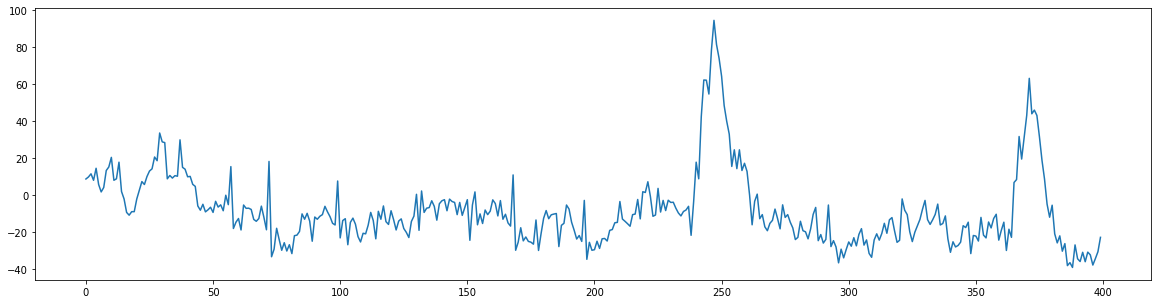

In [ ]:
plot(Xs[0, :, 12])

In [ ]:
Xs = np.reshape(Xs, (Xs.shape[0], 1, Xs.shape[1], Xs.shape[2]))

In [ ]:
Xs.shape

(41600, 1, 400, 62)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.99, random_state=42)
X_train.shape, X_test.shape

((416, 1, 400, 62), (41184, 1, 400, 62))

In [ ]:
Xs = None
gc.collect()

2691

In [ ]:
from tensorflow.keras.utils import to_categorical
X_val = X_test
y_val = y_test
y_train_c = to_categorical(y_train)
y_val_c = to_categorical(y_val)

In [ ]:
y_train_c.shape,y_val_c.shape, y_val.shape

((416, 4), (41184, 4), (41184,))

# Load Test

In [ ]:
#! wget http://34.135.91.113/machifile/session1.zip
#! wget http://34.135.91.113/machifile/session2.zip

!curl ipinfo.io

project_id = 'poc01-320504'
!gcloud config set project {project_id}

#!gsutil cp -v gs://eeg-machima/session1.zip 
#!gsutil cp -v gs://eeg-machima/session2.zip .
!gsutil cp -v gs://eeg-machima/x_test.npy .

{
  "ip": "35.229.221.177",
  "hostname": "177.221.229.35.bc.googleusercontent.com",
  "city": "Taipei",
  "region": "Taiwan",
  "country": "TW",
  "loc": "25.0478,121.5319",
  "org": "AS396982 Google LLC",
  "timezone": "Asia/Taipei",
  "readme": "https://ipinfo.io/missingauth"
}Updated property [core/project].
Copying gs://eeg-machima/x_test.npy...
Created: file://./x_test.npy

Operation completed over 1 objects/756.8 MiB.                                    


In [ ]:
x_test = np.load("/content/x_test.npy")

In [ ]:
x_test.shape

(400, 62, 4000)

In [ ]:
xs = []
for i in range(400):
    xs.append(x_test[i].T)
xs = np.array(xs)

In [ ]:
index = np.linspace(0, 4000, 400, endpoint=False).astype(dtype=np.int32)

xs400 = xs[:, index, :]
xs400.shape

(400, 400, 62)

In [ ]:
index = np.linspace(0, 4000, 400, endpoint=False).astype(dtype=np.int32)
len(index)

400

In [ ]:
xs400 = xs400.reshape( (xs400.shape[0], 1, xs400.shape[1], xs400.shape[2] ) )
xs400.shape

(400, 1, 400, 62)

# ML

In [ ]:
!gdown --id 1EfJmfS-wben3NWdAINllAT6E1Ddn3Ay1

Downloading...
From: https://drive.google.com/uc?id=1EfJmfS-wben3NWdAINllAT6E1Ddn3Ay1
To: /content/M3-20220401T125130Z-001.zip
100% 11.4M/11.4M [00:00<00:00, 118MB/s]


In [ ]:
!unzip /content/M3-20220401T125130Z-001.zip -d ./

Archive:  /content/M3-20220401T125130Z-001.zip
  inflating: ./M3/MIN2Net_time_log.csv  
  inflating: ./M3/MIN2Net_out_log.log  
   creating: ./M3/MIN2Net47_out_weights.tf/assets/
  inflating: ./M3/MIN2Net47_out_weights.tf/keras_metadata.pb  
  inflating: ./M3/MIN2Net47_out_weights.tf/saved_model.pb  
  inflating: ./M3/MIN2Net47_out_weights.tf/variables/variables.index  
  inflating: ./M3/MIN2Net47_out_weights.tf/variables/variables.data-00000-of-00001  


In [ ]:
min2Net = MIN2Net(input_shape=(1, 400, 62), num_class=4, log_path='/content/Machi2Net',
                  loss=[mean_squared_error, triplet_loss(margin=1.0), 'sparse_categorical_crossentropy'],
                  loss_weights=[0.001, 0.1, 1.], 
                  batch_size= 128,
                  #loss=[mean_squared_error, 'sparse_categorical_crossentropy'],
                  #loss_weights=[1., 1.], 
                monitor='val_loss', shuffle=True)

In [ ]:
model = min2Net.build()
model.summary()
min2Net.weights_dir = "/content/M3/MIN2Net47_out_weights.tf"
# min2Net.weights_dir = "/content/Machi2Net/MIN2Net47_out_weights.tf"
model.load_weights(min2Net.weights_dir)
# ypred = model.predict(xs400)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 400, 62)]      0         
                                                                 
 conv2d (Conv2D)             (None, 1, 400, 62)        246078    
                                                                 
 batch_normalization (BatchN  (None, 1, 400, 62)       248       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 1, 200, 62)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 200, 64)        254016    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 200, 64)       256 

In [ ]:
pred = model.predict(X_val)

In [ ]:
pred[0].shape,pred[1].shape,pred[2].shape 

In [ ]:
y_val

In [ ]:
pred[1]

# Pycaret

In [ ]:
import pandas as pd

In [ ]:
df__ = pd.DataFrame(pred[1])
df__

In [ ]:
df__['Class'] = y_val

In [ ]:
df__

In [ ]:
!pip -q install pycaret

     |████████████████████████████████| 319 kB 4.1 MB/s 
     |████████████████████████████████| 16.5 MB 70.6 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 
     |████████████████████████████████| 261 kB 72.2 MB/s 
     |████████████████████████████████| 1.7 MB 55.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 114 kB 83.4 MB/s 
     |████████████████████████████████| 1.3 MB 64.4 MB/s 
     |████████████████████████████████| 6.8 MB 56.6 MB/s 
     |████████████████████████████████| 2.0 MB 47.3 MB/s 
     |████████████████████████████████| 56 kB 5.7 MB/s 
     |████████████████████████████████| 167 kB 86.7 MB/s 
     |████████████████████████████████| 3.1 MB 57.0 MB/s 
     |████████████████████████████████| 63 kB 769 kB/s 
     |████████████████████████████████| 102 kB 15.8 MB/s 
     |███████████████████

In [ ]:
from pycaret.utils import enable_colab
enable_colab()
from pycaret.datasets import get_data
from pycaret.classification import *

In [ ]:
exp_clf101 = setup(data = df__, target = 'Class', session_id=123) 

In [ ]:
best_model = compare_models()

In [ ]:
print(best_model)

In [ ]:
dt = create_model('nb', fold = 15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7526,0.9266,0.7476,0.7580,0.7489,0.6688,0.6726
1,0.7423,0.9347,0.7406,0.7458,0.7423,0.6554,0.6566
2,0.8247,0.9578,0.8216,0.8337,0.8248,0.7655,0.7686
3,0.7526,0.9352,0.7489,0.7513,0.7511,0.6695,0.6699
4,0.7732,0.9236,0.7769,0.7895,0.7703,0.6981,0.7044
5,0.8144,0.9608,0.8167,0.8246,0.8139,0.7528,0.7558
6,0.8351,0.9522,0.8367,0.8402,0.8361,0.7802,0.7812
7,0.7526,0.9443,0.7510,0.7554,0.7527,0.6697,0.6704
8,0.8454,0.9605,0.8435,0.8488,0.8447,0.7935,0.7950


In [ ]:
print(dt)

GaussianNB(priors=None, var_smoothing=1e-09)


In [ ]:
tuned_dt = tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7671,0.9388,0.7639,0.7735,0.7652,0.6886,0.6918
1,0.7808,0.9409,0.7789,0.7884,0.7813,0.7070,0.7091
2,0.7808,0.9388,0.7803,0.7848,0.7814,0.7077,0.7086
3,0.7945,0.9461,0.7972,0.7994,0.7939,0.7263,0.7282
4,0.8014,0.9520,0.8018,0.8071,0.8031,0.7352,0.7360
5,0.8276,0.9571,0.8259,0.8280,0.8274,0.7696,0.7699
6,0.7724,0.9433,0.7720,0.7714,0.7714,0.6960,0.6963
7,0.7862,0.9532,0.7807,0.8080,0.7820,0.7136,0.7221
8,0.7862,0.9402,0.7836,0.7983,0.7841,0.7143,0.7192


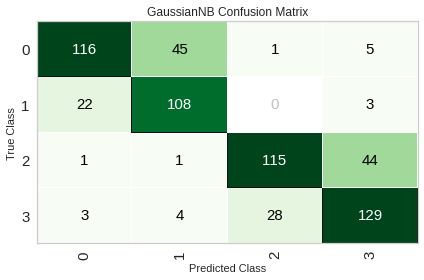

In [ ]:
plot_model(tuned_dt, plot = 'confusion_matrix')

In [ ]:
predict_model(tuned_dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7488,0.9394,0.7519,0.7565,0.7491,0.6651,0.6672


,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,Class,Label,Score
0,0.460974,1.273098,0.635140,0.438225,0.278127,-2.471037,0.066726,0.196247,1.195538,-1.975194,...,-0.094295,-2.619984,-1.687033,0.083782,-0.491609,-2.253652,-1.075906,3,3,1.0000
1,0.708808,2.042991,2.247365,1.944105,-0.651544,-0.011803,0.627519,0.039499,2.939354,1.295816,...,-1.266197,0.649260,1.820406,3.380170,1.201433,-0.135438,2.773808,3,3,1.0000
2,-0.365238,1.733966,-5.350283,-2.559039,0.297358,-0.279925,-0.434899,-0.105358,-0.908104,2.371387,...,-0.962319,-0.363367,0.284158,-9.801751,-4.881250,0.216509,-6.807786,0,1,1.0000
3,0.571819,0.936879,0.805507,0.719075,-0.262872,-1.684544,0.433250,0.179519,1.245797,-1.013813,...,0.010963,-1.574170,-0.998223,0.379672,0.479108,-1.000032,-0.696975,3,3,1.0000
4,-0.415995,0.924849,0.585437,0.651579,-0.806515,0.168054,-0.348636,-0.024593,0.972811,0.993413,...,-1.099218,0.477105,0.837258,2.614483,-0.024753,0.184195,2.132117,3,2,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,-0.733391,0.614194,-4.263591,-2.336136,-1.002350,-0.065838,-1.165652,-0.778739,-1.144925,1.655708,...,-1.790576,-0.776323,-0.306640,-6.800532,-4.469622,-0.311640,-4.514162,0,0,1.0000
621,-0.099284,0.775446,0.362740,0.529951,-0.189024,-0.211830,-0.175091,0.050914,0.985965,0.904680,...,-0.788763,-0.014901,0.280613,1.084466,-0.205470,0.159408,0.949342,2,3,0.8764
622,1.570731,3.277478,-4.227101,-0.103523,1.996396,2.050978,1.014302,2.586194,0.725295,3.058622,...,1.607254,1.165384,1.154008,-9.544950,-3.060391,1.580348,-7.448833,1,1,1.0000
623,0.139741,1.600439,-3.557028,-0.970679,0.709130,1.033158,-0.136824,1.015341,-0.024333,2.155738,...,-0.003168,0.308545,0.419531,-7.028016,-3.254911,0.734910,-5.075973,1,1,1.0000


In [ ]:
final_rf = finalize_model(tuned_dt)

In [ ]:
predict_model(final_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7504,0.9393,0.7534,0.7577,0.7507,0.6672,0.6692


,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,Class,Label,Score
0,0.460974,1.273098,0.635140,0.438225,0.278127,-2.471037,0.066726,0.196247,1.195538,-1.975194,...,-0.094295,-2.619984,-1.687033,0.083782,-0.491609,-2.253652,-1.075906,3,3,1.0000
1,0.708808,2.042991,2.247365,1.944105,-0.651544,-0.011803,0.627519,0.039499,2.939354,1.295816,...,-1.266197,0.649260,1.820406,3.380170,1.201433,-0.135438,2.773808,3,3,1.0000
2,-0.365238,1.733966,-5.350283,-2.559039,0.297358,-0.279925,-0.434899,-0.105358,-0.908104,2.371387,...,-0.962319,-0.363367,0.284158,-9.801751,-4.881250,0.216509,-6.807786,0,1,1.0000
3,0.571819,0.936879,0.805507,0.719075,-0.262872,-1.684544,0.433250,0.179519,1.245797,-1.013813,...,0.010963,-1.574170,-0.998223,0.379672,0.479108,-1.000032,-0.696975,3,3,1.0000
4,-0.415995,0.924849,0.585437,0.651579,-0.806515,0.168054,-0.348636,-0.024593,0.972811,0.993413,...,-1.099218,0.477105,0.837258,2.614483,-0.024753,0.184195,2.132117,3,2,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,-0.733391,0.614194,-4.263591,-2.336136,-1.002350,-0.065838,-1.165652,-0.778739,-1.144925,1.655708,...,-1.790576,-0.776323,-0.306640,-6.800532,-4.469622,-0.311640,-4.514162,0,0,1.0000
621,-0.099284,0.775446,0.362740,0.529951,-0.189024,-0.211830,-0.175091,0.050914,0.985965,0.904680,...,-0.788763,-0.014901,0.280613,1.084466,-0.205470,0.159408,0.949342,2,3,0.9389
622,1.570731,3.277478,-4.227101,-0.103523,1.996396,2.050978,1.014302,2.586194,0.725295,3.058622,...,1.607254,1.165384,1.154008,-9.544950,-3.060391,1.580348,-7.448833,1,1,1.0000
623,0.139741,1.600439,-3.557028,-0.970679,0.709130,1.033158,-0.136824,1.015341,-0.024333,2.155738,...,-0.003168,0.308545,0.419531,-7.028016,-3.254911,0.734910,-5.075973,1,1,1.0000


In [ ]:
# from pycaret.utils import check_metric
# check_metric(unseen_predictions['fontWeight'], unseen_predictions['Label'], metric = 'Accuracy')

In [ ]:
save_model(final_rf,'v1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Class')),
                 ('fix_perfect', Remove_100(target='Class')),
                 ('clean_names', Cl

In [ ]:
pred = model.predict(xs400)

In [ ]:
data_unseen = pd.DataFrame(pred[1])
data_unseen

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.559110,-0.200742,-3.514130,-2.976987,-2.669188,-1.083239,-1.281322,-1.835788,-0.915643,0.210447,...,3.206765,1.455761,-0.967201,-2.234253,-2.018332,-1.105918,-5.007425,-4.093046,-1.760566,-3.299510
1,-2.144248,0.529764,-1.025108,0.373746,-2.717386,3.329072,-2.098279,-1.106172,0.703766,4.928172,...,0.426444,-4.993831,-1.467483,-2.884295,3.969051,4.574518,2.786734,-0.775027,2.900971,4.558787
2,0.408707,1.237866,-0.222968,-0.204819,-0.119936,-2.461414,0.390252,0.232911,1.081493,-1.636917,...,0.857446,2.281535,-0.041286,-0.019953,-2.947902,-1.951095,-2.343472,-0.875693,-2.173381,-2.752163
3,0.665264,1.851253,-3.064361,-0.553903,1.057488,-0.834823,0.102159,0.958502,0.700653,-0.281319,...,0.586786,0.349982,1.147271,0.714805,-1.106765,-0.612698,-8.652266,-2.721498,-0.406069,-6.804747
4,-1.129830,0.730897,-2.505027,-1.517690,-1.867704,-0.703376,-0.911414,-1.277953,0.231294,0.938269,...,1.771333,-0.150162,-0.628050,-2.134583,-0.967180,0.259809,-4.834188,-3.230813,-1.026140,-3.136860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.532546,0.726563,-4.457717,-2.302170,-0.283226,-0.572194,-0.669190,-0.196545,-0.606268,1.034279,...,2.156393,1.198673,0.262520,-1.006986,-1.753454,-1.151003,-9.107297,-5.156382,-0.993912,-6.496917
396,0.393107,1.105368,0.615581,0.271809,-0.971662,-0.942002,0.295345,-0.358526,1.158826,-0.413709,...,0.300643,0.104146,0.431836,-0.344079,-0.948733,-0.153525,0.783395,0.310654,-1.044067,0.159161
397,1.312827,2.315080,0.986798,1.300490,-1.317449,-1.186446,1.027493,0.357451,2.635442,-1.150446,...,-0.354985,0.111896,1.354984,-0.799936,-1.233931,0.243111,0.071769,1.077925,-1.460654,-1.138692
398,-2.168608,-1.115364,-3.716579,-3.379360,-2.654850,-0.645893,-2.514122,-2.311793,-1.063728,-0.309863,...,3.655106,0.813253,-2.018335,-2.794837,-1.805616,-0.636229,-4.833502,-4.876897,-1.428082,-2.440102


In [ ]:
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.head(20)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,Label,Score
0,-1.559110,-0.200742,-3.514130,-2.976987,-2.669188,-1.083239,-1.281322,-1.835788,-0.915643,0.210447,...,-0.967201,-2.234253,-2.018332,-1.105918,-5.007425,-4.093046,-1.760566,-3.299510,0,1.0000
1,-2.144248,0.529764,-1.025108,0.373746,-2.717386,3.329072,-2.098279,-1.106172,0.703766,4.928172,...,-1.467483,-2.884295,3.969051,4.574518,2.786734,-0.775027,2.900971,4.558787,2,1.0000
2,0.408707,1.237866,-0.222968,-0.204819,-0.119936,-2.461414,0.390252,0.232911,1.081493,-1.636917,...,-0.041286,-0.019953,-2.947902,-1.951095,-2.343472,-0.875693,-2.173381,-2.752163,3,1.0000
3,0.665264,1.851253,-3.064361,-0.553903,1.057488,-0.834823,0.102159,0.958502,0.700653,-0.281319,...,1.147271,0.714805,-1.106765,-0.612698,-8.652266,-2.721498,-0.406069,-6.804747,1,1.0000
4,-1.129830,0.730897,-2.505027,-1.517690,-1.867704,-0.703376,-0.911414,-1.277953,0.231294,0.938269,...,-0.628050,-2.134583,-0.967180,0.259809,-4.834188,-3.230813,-1.026140,-3.136860,0,1.0000
5,-1.036968,0.878414,0.351710,0.393372,-2.057578,0.984600,-0.814205,-0.582624,1.493819,2.380412,...,-0.505620,-2.103848,1.099511,1.719923,2.555158,-0.379731,0.626933,3.024578,2,1.0000
6,-0.356563,0.717151,-3.558767,-2.237788,-0.963791,-1.194350,-0.623025,-1.010267,-0.232933,-0.321151,...,-0.072595,-1.569614,-2.281577,-1.246128,-7.313645,-4.345600,-1.690754,-5.335391,0,1.0000
7,2.170811,3.010427,2.260281,2.667057,1.001796,-1.310013,1.659754,1.245274,2.854989,-0.777358,...,1.589420,0.749883,-0.531340,0.512559,1.436927,2.209012,-0.651258,-0.115390,3,1.0000
8,0.543730,1.682976,-1.368179,-0.337070,-0.418414,-2.310342,0.779264,0.558420,1.250954,-1.356228,...,1.158665,0.265395,-2.720477,-1.933618,-4.680470,-1.802963,-2.414276,-4.954388,0,1.0000
9,1.249730,2.406303,-3.440070,-0.698552,0.812249,-0.555357,0.749343,1.124494,0.886351,0.446790,...,2.724614,0.674214,-1.641712,-0.964396,-9.816683,-3.353074,-1.176672,-7.979071,1,1.0000


In [ ]:
clf_pred = list(unseen_predictions['Label'])
clf_pred

[0,
 2,
 3,
 1,
 0,
 2,
 0,
 3,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 3,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 3,
 2,
 1,
 1,
 1,
 1,
 0,
 0,
 3,
 1,
 0,
 3,
 3,
 0,
 3,
 2,
 3,
 0,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 3,
 0,
 0,
 1,
 3,
 0,
 0,
 1,
 3,
 2,
 2,
 1,
 2,
 0,
 3,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 0,
 3,
 3,
 1,
 0,
 0,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 0,
 1,
 0,
 1,
 2,
 3,
 2,
 1,
 1,
 3,
 0,
 3,
 2,
 3,
 0,
 2,
 2,
 0,
 1,
 3,
 2,
 3,
 0,
 2,
 2,
 2,
 3,
 0,
 3,
 2,
 0,
 3,
 1,
 3,
 3,
 3,
 2,
 0,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 1,
 3,
 3,
 0,
 1,
 3,
 1,
 0,
 1,
 3,
 0,
 0,
 1,
 0,
 2,
 3,
 3,
 3,
 3,
 3,
 0,
 2,
 1,
 3,
 0,
 2,
 3,
 1,
 2,
 0,
 1,
 2,
 0,
 2,
 3,
 3,
 2,
 2,
 0,
 0,
 0,
 3,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 2,
 3,
 1,
 2,
 3,
 3,
 0,
 2,
 3,
 3,
 2,
 2,
 2,
 1,
 3,
 0,
 2,
 3,
 3,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 1,
 3,
 3,
 1,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 1,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 0,
 0,
 2,


In [ ]:
ids = []
predicts = []
for i in range(800):
    
    if i < 400:
        predicts.append(clf_pred[i])
        ids.append(str(i+1))
    else:
        predicts.append(0)
        ids.append("f"+str(i-400+1))

len(ids),len(predicts)

(800, 800)

In [ ]:
import pandas as pd

submission = pd.DataFrame(data={'sample_id':ids,'prediction': predicts})
submission

,sample_id,prediction
0,1,0
1,2,2
2,3,3
3,4,1
4,5,0
...,...,...
795,f396,0
796,f397,0
797,f398,0
798,f399,0


In [ ]:
submission.to_csv("NB_FIRST_HOPE.csv", index = False)